In [37]:
import logging

import sep
import pickle

import numpy as np
from scipy import ndimage

from PIL import Image

import scarlet
import scarlet.display

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')

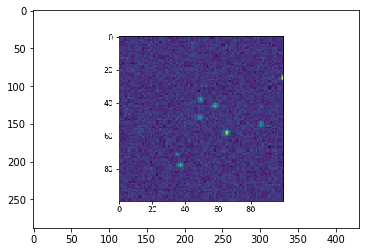

In [38]:
fake1 = ("/Users/dylanhilligoss/Desktop/FakeImage1.png")
img1 = Image.open(fake1)
data = np.array(img1)
data1 = np.save( fake1 + '.npz', data)
plt.imshow(img1)

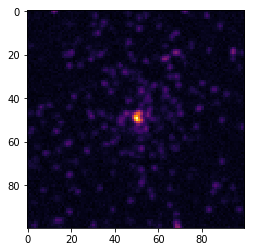

In [39]:
img1 = np.load("fake1.npy")
plt.imshow(img1)

In [40]:
data2 = np.load("fake1.npy")
catalog = pickle.load(open("data.pickle", "rb" ))
bg_rms = np.array([20]*len(data2))

In [41]:
def makeCatalog(img):
    detect = img#.mean(axis=0) # simple average for detection
    bkg = sep.Background(detect)
    catalog = sep.extract(detect, 1.5, err=bkg.globalrms)
    bg_rms = np.array([sep.Background(band).globalrms for band in [img,img,img]])
    return catalog, bg_rms
catalog, bg_rms = makeCatalog(data2)

In [42]:
norm = scarlet.display.Asinh(img=np.array([data2,data2,data2]), Q=20)
filter_indices = [3,2,1]
img_rgb = scarlet.display.img_to_rgb(np.array([data2,data2,data2]), filter_indices=filter_indices, norm=norm)
plt.imshow(img_rgb)
for src in catalog:
    plt.plot(src["x"], src["y"], "rx", mew=2)
plt.show()

IndexError: index 3 is out of bounds for axis 0 with size 3